<a href="https://colab.research.google.com/github/skywalker0803r/x3d/blob/main/x3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ÂÆöÁæ©Ë≥áÊñôÈõÜ

Balanced dataset: 326 samples (strike: 163, not strike: 163)
Balanced dataset: 332 samples (strike: 166, not strike: 166)
Balanced dataset: 388 samples (strike: 194, not strike: 194)
üì¶ Ë®ìÁ∑¥Ë≥áÊñôÁØÑ‰æã


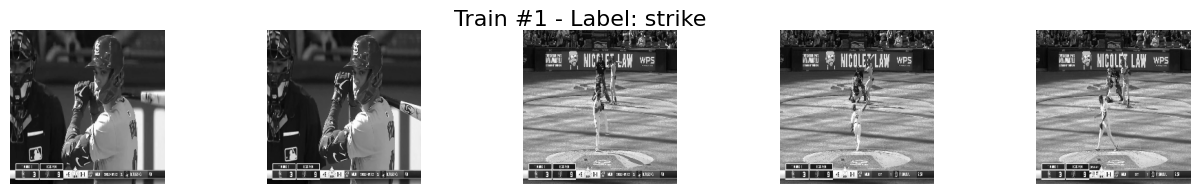

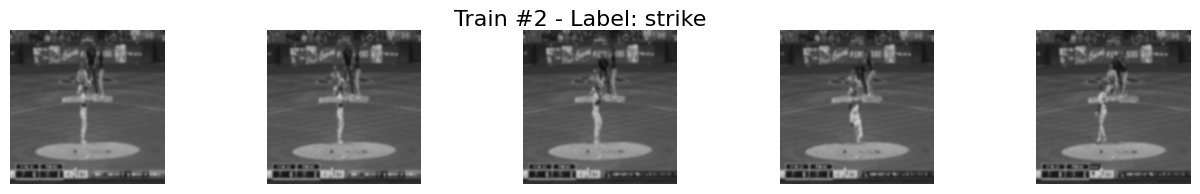

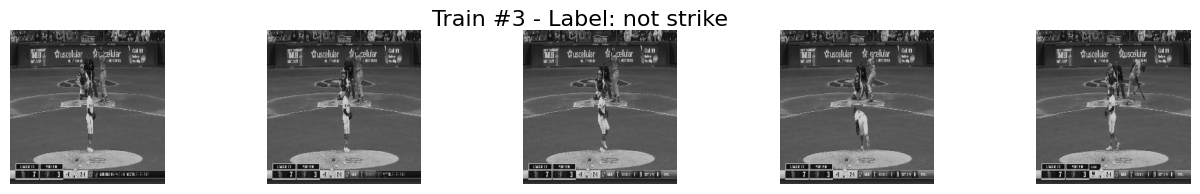

üß™ È©óË≠âË≥áÊñôÁØÑ‰æã


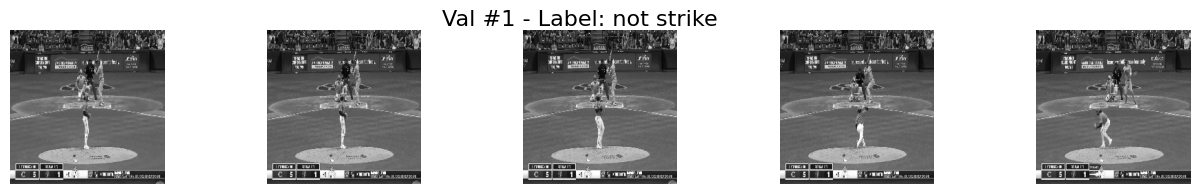

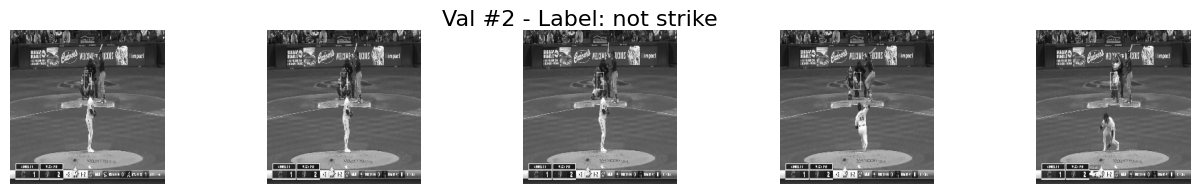

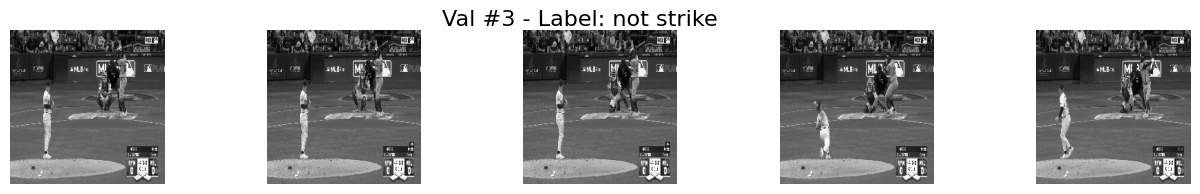

In [13]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from pytorchvideo.models.hub import x3d_xs
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_video
from torchvision import transforms as T
import cv2
import numpy as np
from torchvision import transforms
import random
from PIL import Image
from torch.utils.data import ConcatDataset
from torch.utils.data import Subset
import copy
from PIL import Image, ImageFilter
import warnings
warnings.filterwarnings('ignore')

def read_video_cv2(path, max_frames=240, sample_frames=120):
    # ÈñãÂïüÂΩ±ÁâáÊ™îÊ°à
    cap = cv2.VideoCapture(path)
    frames = []

    # ÈÄêÂπÄËÆÄÂèñÂΩ±ÁâáÁõ¥Âà∞ÁµêÊùü
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Â¶ÇÊûúËÆÄ‰∏çÂà∞ÔºàÂΩ±ÁâáÁµêÊùüÔºâÔºåÂ∞±Ë∑≥Âá∫
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGRËΩâRGB
        frames.append(frame)

    # ÈáãÊîæÂΩ±ÁâáË≥áÊ∫ê
    cap.release()

    # Ëã•ËÆÄ‰∏çÂà∞‰ªª‰ΩïÂπÄÔºå‰∏üÂá∫ÈåØË™§
    total_frames = len(frames)
    if total_frames == 0:
        raise RuntimeError(f"Cannot read video {path}")

    # Ëã•ÂΩ±ÁâáÂπÄÊï∏‰∏çË∂≥ max_framesÔºåÈáçË§áÊúÄÂæå‰∏ÄÂπÄ‰æÜË£úË∂≥Èï∑Â∫¶
    while len(frames) < max_frames:
        frames.append(frames[-1].copy())

    # ÈôêÂà∂ÊúÄÂ§öÂè™Âèñ max_frames ÂπÄ
    frames = frames[:max_frames]

    # Á≠âË∑ùÂú∞ÈÅ∏Âá∫ sample_frames ÂπÄÁ¥¢Âºï‰ΩçÁΩÆ
    indices = np.linspace(0, max_frames - 1, sample_frames).astype(int)

    # Ê†πÊìöÁ¥¢ÂºïÂèñÂá∫Â∞çÊáâÁöÑÂπÄ
    sampled_frames = [frames[i] for i in indices]

    # Â∞áÂπÄÂàóË°®ËΩâÊàê NumPy Èô£Âàó (T, H, W, C)
    video_np = np.stack(sampled_frames, axis=0)

    # ËΩâÊàê PyTorch Tensor ‰∏¶ÈáçÊñ∞ÊéíÂàóÁ∂≠Â∫¶ÁÇ∫ (C, T, H, W)
    video_t = torch.from_numpy(video_np).permute(3, 0, 1, 2)

    # ÂõûÂÇ≥ÂΩ±ÁâáÂºµÈáè
    return video_t

# Ë≥áÊñôÊ®°Âûã
class Normalize(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()  # ÁπºÊâøËá™ nn.Module ÁöÑÂàùÂßãÂåñ
        # Â∞á mean ËΩâÊàêÂºµÈáèÔºå‰∏¶ reshape Êàê (C, 1, 1, 1)ÔºåÊñπ‰æøËàá (C, T, H, W) ÁöÑÂΩ±ÂÉèÈÄ≤Ë°å broadcast
        self.mean = torch.tensor(mean).view(-1, 1, 1, 1)
        # Â∞á std ËΩâÊàêÂºµÈáèÔºå‰∏¶ reshape Êàê (C, 1, 1, 1)ÔºåÊñπ‰æøËàáÂΩ±ÂÉèË≥áÊñôÈÄ≤Ë°åÈô§Ê≥ï broadcast
        self.std = torch.tensor(std).view(-1, 1, 1, 1)

    def forward(self, x):
        # Â∞çËº∏ÂÖ•ÂºµÈáè x ÂÅöÊ®ôÊ∫ñÂåñÔºöÊØèÂÄã channel Ê∏õÂéªÂπ≥ÂùáÂÄº„ÄÅÈô§‰ª•Ê®ôÊ∫ñÂ∑Æ
        return (x - self.mean) / self.std


# üîß ÂÆâÂÖ®Ë≥áÊñôÂ¢ûÂº∑
class SafeVideoAugmentation:
    def __init__(self, resize=(224, 224), apply_blur_prob=0.3, apply_brightness_prob=0.3):
        # Ë®≠ÂÆöÊØèÂπÄÂΩ±ÂÉèÁöÑ resize Â§ßÂ∞è
        self.resize = resize

        # ÂÆöÁæ©Â∞á PIL ÂΩ±ÂÉèËΩâÊàê tensor ÁöÑËΩâÊèõÂô® (0~1 ÁØÑÂúç)
        self.to_tensor = transforms.ToTensor()

        # ÂÆöÁæ©ÊáâÁî®Ê®°Á≥äÁöÑÊ©üÁéá
        self.apply_blur_prob = apply_blur_prob

        # ÂÆöÁæ©ÊáâÁî®‰∫ÆÂ∫¶Ë™øÊï¥ÁöÑÊ©üÁéá
        self.apply_brightness_prob = apply_brightness_prob

        # ÂÆöÁæ©ÂΩ±ÁâáÁöÑÊ®ôÊ∫ñÂåñÊñπÂºè (‰ΩøÁî® ImageNet Ê®ôÊ∫ñ)
        self.normalize = Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])

    def __call__(self, frames):
        augmented = []  # Áî®‰æÜÂÑ≤Â≠òÂ¢ûÂº∑ÂæåÁöÑÊØè‰∏ÄÂπÄ

        # Èö®Ê©üÊ±∫ÂÆöÊòØÂê¶Â∞çÊï¥ÂÄãÂΩ±ÁâáÊáâÁî®Ê®°Á≥ä
        apply_blur = random.random() < self.apply_blur_prob

        # Èö®Ê©üÊ±∫ÂÆöÊòØÂê¶Â∞çÊï¥ÂÄãÂΩ±ÁâáÊáâÁî®‰∫ÆÂ∫¶Ë™øÊï¥
        apply_brightness = random.random() < self.apply_brightness_prob

        # Èö®Ê©üÁî¢Áîü‰∏ÄÂÄã‰∫ÆÂ∫¶Ë™øÊï¥‰øÇÊï∏ (0.8~1.2 ‰πãÈñì)
        brightness_factor = random.uniform(0.8, 1.2)

        # ÈÅçÊ≠∑ÊØè‰∏ÄÂπÄÂÅöÂ¢ûÂº∑ËôïÁêÜ
        for frame in frames:
            # Â∞áÂΩ±ÂÉè resize ÊàêÂõ∫ÂÆöÂ§ßÂ∞è
            frame = cv2.resize(frame, self.resize)

            # Â∞á NumPy Èô£ÂàóËΩâÁÇ∫ PIL ÂΩ±ÂÉèÔºåÊñπ‰æøÂæåÁ∫å‰ΩøÁî® PIL ÁöÑÂΩ±ÂÉèÂ¢ûÂº∑ÊñπÊ≥ï
            pil_frame = Image.fromarray(frame)

            # Ëã•Ë¶ÅÂ•óÁî®Ê®°Á≥äÔºåÂâáÂä†‰∏ä GaussianBlur
            if apply_blur:
                pil_frame = pil_frame.filter(ImageFilter.GaussianBlur(radius=1.5))  # radius ÊéßÂà∂Ê®°Á≥äÂº∑Â∫¶

            # Ëã•Ë¶ÅÂ•óÁî®‰∫ÆÂ∫¶Ë™øÊï¥ÔºåÂâáÈÄ≤Ë°å‰∫ÆÂ∫¶Â¢ûÂº∑
            if apply_brightness:
                pil_frame = transforms.functional.adjust_brightness(pil_frame, brightness_factor)

            # ‚úÖ Â∞áÂΩ©Ëâ≤ÂΩ±ÂÉèËΩâÁÇ∫ÁÅ∞ÈöéÔºàÂñÆÈÄöÈÅìÔºâÂÜçËΩâÂõû RGBÔºà‰∏âÈÄöÈÅìÔºâ
            gray_frame = pil_frame.convert("L")         # ËΩâÁÅ∞Èöé
            gray_frame = gray_frame.convert("RGB")      # ÂÜçËΩâÂõû RGBÔºàR=G=BÔºâ

            # Â∞á PIL ÂΩ±ÂÉèËΩâÊàê tensorÔºåÂΩ¢ÁãÄÁÇ∫ (C, H, W)ÔºåÂÄºÂú® 0~1
            tensor_frame = self.to_tensor(gray_frame)

            # Âä†ÂÖ•Â¢ûÂº∑ÂæåÁöÑÂπÄ
            augmented.append(tensor_frame)

        # Â∞áÊâÄÊúâÂπÄÂ†ÜÁñäËµ∑‰æÜÊàê (T, C, H, W)
        augmented_tensor = torch.stack(augmented)

        # Â∞áÁ∂≠Â∫¶ËΩâÊèõÊàê (C, T, H, W)ÔºåÁ¨¶ÂêàÂΩ±ÁâáÊ®°ÂûãËº∏ÂÖ•Ê†ºÂºè
        augmented_tensor = augmented_tensor.permute(1, 0, 2, 3)

        # Â∞çÊï¥ÊÆµÂΩ±ÁâáÂºµÈáèÂÅöÊ®ôÊ∫ñÂåñËôïÁêÜ
        augmented_tensor = self.normalize(augmented_tensor)

        # ÂõûÂÇ≥Â¢ûÂº∑ËàáÊ®ôÊ∫ñÂåñÂæåÁöÑÂΩ±ÁâáÂºµÈáè
        return augmented_tensor #ÊàëÂ∏åÊúõÂ∞áÂΩ±ÁâáËΩâÁÅ∞Èöé‰ΩÜÊòØ‰øùÁïôÈÄöÈÅìÊï∏

class VideoDataset(Dataset):
    def __init__(self, csv_path, video_dir, original_frames=240, sample_frames=120, transform=None):
        # ÂÑ≤Â≠òÂΩ±ÁâáË≥áÊñôÂ§æË∑ØÂæë
        self.video_dir = video_dir

        # Ë®òÈåÑÂéüÂßãÂΩ±ÁâáÈï∑Â∫¶ÔºàÊúÄÂ§ßÂπÄÊï∏Ôºâ
        self.original_frames = original_frames

        # ÊåáÂÆöË¶ÅÁ≠âË∑ùÊäΩÊ®£ÁöÑÂπÄÊï∏ÔºàÊ®°ÂûãËº∏ÂÖ•Èï∑Â∫¶Ôºâ
        self.sample_frames = sample_frames

        # Â¶ÇÊûúÊ≤íÊúâÊåáÂÆö transformÔºåÂ∞±‰ΩøÁî®Ëá™Ë®ÇÁöÑ SafeVideoAugmentation Â¢ûÂº∑ÊñπÊ≥ï
        self.transform = transform or SafeVideoAugmentation()

        # ËÆÄÂèñÊ®ôË®ªÊ™î CSVÔºåÂåÖÂê´ filename Ëàá description Ê¨Ñ‰Ωç
        self.data = pd.read_csv(csv_path)

        # ÂÆöÁæ©‰∏ÄÂÄãÂÖßÈÉ®ÂáΩÊï∏‰æÜÊ™¢Êü•Ê™îÊ°àÊòØÂê¶Â≠òÂú®
        def file_exists(filename):
            return os.path.isfile(os.path.join(video_dir, filename))

        # Âè™‰øùÁïôÂΩ±ÁâáÊ™îÊ°àÂ≠òÂú®ÁöÑË≥áÊñôÂàó
        mask = self.data['filename'].apply(file_exists)
        filtered_data = self.data[mask].reset_index(drop=True)

        # Ëã•ÊúâÈÅ∫Â§±Ê™îÊ°àÂâáÈ°ØÁ§∫Ë≠¶ÂëäË®äÊÅØ
        num_removed = len(self.data) - len(filtered_data)
        if num_removed > 0:
            print(f"Warning: removed {num_removed} entries because video files not found")
        self.data = filtered_data

        # Ê†πÊìö description ÊòØÂê¶ÂåÖÂê´ 'strike' ‰æÜÂª∫Á´ã labelÔºàstrike ÁÇ∫ 1ÔºåÂÖ∂È§òÁÇ∫ 0Ôºâ
        self.data['label'] = self.data['description'].str.contains('strike', case=False).astype(int)

        # === Âπ≥Ë°° strike / not strike ÁöÑÊ®£Êú¨Êï∏ ===
        # ÂàÜÈñãÂÖ©ÂÄãÈ°ûÂà•
        strike_data = self.data[self.data['label'] == 1]
        not_strike_data = self.data[self.data['label'] == 0]

        # ÂèñÂæóÂÖ©ÂÄãÈ°ûÂà•‰∏≠Ê®£Êú¨Êï∏ËºÉÂ∞èÁöÑÂÄº
        min_len = min(len(strike_data), len(not_strike_data))

        # ÂæûÂÖ©È°ûÂà•‰∏≠ÂêÑËá™Èö®Ê©üÊäΩÊ®£ min_len Á≠Ü
        strike_sampled = strike_data.sample(min_len, random_state=42)
        not_strike_sampled = not_strike_data.sample(min_len, random_state=42)

        # Âêà‰ΩµÂÖ©È°û‰∏¶Êâì‰∫ÇÈ†ÜÂ∫èÔºåÈáçË®≠ index
        self.data = pd.concat([strike_sampled, not_strike_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
        print(f"Balanced dataset: {len(self.data)} samples (strike: {min_len}, not strike: {min_len})")

    def __len__(self):
        # ÂõûÂÇ≥Ê®£Êú¨Á∏ΩÊï∏
        return len(self.data)

    def __getitem__(self, idx):
        # ÂèñÂæóÁ¨¨ idx Á≠ÜË≥áÊñôÁöÑÂÖßÂÆπ
        row = self.data.iloc[idx]

        # Ê†πÊìöÊ™îÂêçÁµÑÂêàÂá∫ÂÆåÊï¥ÂΩ±ÁâáË∑ØÂæë
        video_path = os.path.join(self.video_dir, row['filename'])

        # ÂèñÂæóË©≤Á≠ÜË≥áÊñôÁöÑÊ®ôÁ±§Ôºà0 Êàñ 1Ôºâ
        label = row['label']

        # ËÆÄÂèñÂΩ±Áâá‰∏¶ÈÄ≤Ë°åÊäΩÊ®£ÔºàËº∏Âá∫ÁÇ∫ (C, T, H, W) ÁöÑ tensorÔºâ
        video = read_video_cv2(video_path, self.original_frames, self.sample_frames)

        # Â∞áÂΩ±ÁâáÂºµÈáèÂæû (C, T, H, W) ‚Üí (T, H, W, C)Ôºå‰ª•Á¨¶Âêà transform ÁöÑËôïÁêÜÊ†ºÂºèÔºàOpenCV Ëàá PIL Ê†ºÂºèÔºâ
        video = video.permute(1, 2, 3, 0).numpy()

        # Ëã•ÊúâÊåáÂÆö transformÔºåÂâáÂ•óÁî®Ôºà‰æãÂ¶Ç resize„ÄÅÂ¢ûÂº∑„ÄÅÊ®ôÊ∫ñÂåñÔºâ
        if self.transform:
            video = self.transform(video)

        # ÂõûÂÇ≥ËôïÁêÜÂæåÁöÑÂΩ±ÁâáÂºµÈáèËàáÂÖ∂Ê®ôÁ±§
        return video, label

dataset_paths = [
    {
        "csv_path": "/content/drive/MyDrive/Baseball Movies/CH_videos_4s/CH.csv",
        "video_dir": "/content/drive/MyDrive/Baseball Movies/CH_videos_4s"
    },
    {
        "csv_path": "/content/drive/MyDrive/Baseball Movies/FF_videos_4s/FF.csv",
        "video_dir": "/content/drive/MyDrive/Baseball Movies/FF_videos_4s"
    },
    {
        "csv_path": "/content/drive/MyDrive/Baseball Movies/SL_videos_4s/SL.csv",
        "video_dir": "/content/drive/MyDrive/Baseball Movies/SL_videos_4s"
    },
]

datasets = []
for item in dataset_paths:
    dataset = VideoDataset(
        csv_path=item["csv_path"],
        video_dir=item["video_dir"],
        original_frames=240,
        sample_frames=120,
        transform=None  # ÂÖà‰∏çÂä† transformÔºåÁ®çÂæåË®≠ÁΩÆ
    )
    datasets.append(dataset)

full_dataset = ConcatDataset(datasets)

# 1. ÂàÜÂâ≤ index
val_split = 0.2
dataset_len = len(full_dataset)
indices = list(range(dataset_len))
split = int(val_split * dataset_len)
random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# 2. Âª∫Á´ã train/val datasetÔºå‰∏¶Ë§áË£ΩÂéüÂßã dataset
train_dataset = copy.deepcopy(full_dataset)
val_dataset = copy.deepcopy(full_dataset)

# 3. Ë®≠ÂÆö transform ÂàÜÂà•Áµ¶ train/val dataset
for d in train_dataset.datasets:
    d.transform = SafeVideoAugmentation()

for d in val_dataset.datasets:
    d.transform = SafeVideoAugmentation(apply_blur_prob=0.0, apply_brightness_prob=0.0)

# 4. Âª∫Á´ã Subset
train_set = Subset(train_dataset, train_indices)
val_set = Subset(val_dataset, val_indices)

# 5. Âª∫Á´ã dataloader
batch_size = 10
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

def denormalize(tensor, mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225]):
    # ÈÇÑÂéü Normalize ÈÅéÁöÑ Tensor
    mean = torch.tensor(mean).view(3, 1, 1, 1)
    std = torch.tensor(std).view(3, 1, 1, 1)
    return tensor * std + mean

# Êü•ÁúãË≥áÊñôÈõÜ
import matplotlib.pyplot as plt
def show_video_sample(dataset, index, title=""):
    video, label = dataset[index]  # (C, T, H, W)

    # ‚úÖ ÈÇÑÂéü Normalize ‰∏¶ÈôêÂà∂ÁØÑÂúç
    video = denormalize(video).clamp(0, 1)  # Á¢∫‰øùÂÄºÂú® [0,1]

    # (C, T, H, W) ‚Üí (T, H, W, C) for imshow
    video = video.permute(1, 2, 3, 0).cpu().numpy()

    # ÂèñÂπæÂπÄÂ±ïÁ§∫
    num_frames = video.shape[0]
    sample_indices = np.linspace(0, num_frames - 1, 5).astype(int)

    fig, axes = plt.subplots(1, 5, figsize=(16, 2))
    for i, ax in enumerate(axes):
        ax.imshow(video[sample_indices[i]])
        ax.axis("off")
    plt.suptitle(f"{title} - Label: {'strike' if label==1 else 'not strike'}", fontsize=16)
    plt.show()

# Èö®Ê©üÂ±ïÁ§∫ÂπæÁ≠ÜË®ìÁ∑¥ËàáÈ©óË≠âË≥áÊñô
print("üì¶ Ë®ìÁ∑¥Ë≥áÊñôÁØÑ‰æã")
for i in range(3):
    show_video_sample(train_set, random.randint(0, len(train_set) - 1), title=f"Train #{i+1}")

print("üß™ È©óË≠âË≥áÊñôÁØÑ‰æã")
for i in range(3):
    show_video_sample(val_set, random.randint(0, len(val_set) - 1), title=f"Val #{i+1}")


# ÂÆöÁæ©Ë®ìÁ∑¥ÂíåÈ©óË≠âÂáΩÊï∏

In [14]:
# ------- 1. Ë®ìÁ∑¥ÂáΩÊï∏ --------
def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()  # Ë®≠ÂÆöÊ®°ÂûãÁÇ∫Ë®ìÁ∑¥Ê®°Âºè
    total_loss, correct, total = 0, 0, 0  # ÂàùÂßãÂåñÊêçÂ§±Á∏ΩÂíå„ÄÅÊ≠£Á¢∫È†êÊ∏¨Êï∏Èáè„ÄÅÊ®£Êú¨Êï∏

    for videos, labels in tqdm(loader, desc="Training", leave=False):  # Ëø≠‰ª£Ë®ìÁ∑¥Ë≥áÊñô
        videos, labels = videos.to(device), labels.to(device).long()  # Â∞áË≥áÊñôÁßªÂãïÂà∞ÊåáÂÆöË£ùÁΩÆ‰∏¶ËΩâÊàêlongÂûãÊÖã

        optimizer.zero_grad()  # Ê∏ÖÁ©∫ÂÖàÂâçÊ¢ØÂ∫¶

        with torch.cuda.amp.autocast():  # Ê∑∑ÂêàÁ≤æÂ∫¶Ëá™ÂãïÈÅãÁÆó
            outputs = model(videos)  # ÂâçÂêëÂÇ≥Êí≠ÔºåÂèñÂæóÈ†êÊ∏¨ÁµêÊûú
            loss = criterion(outputs, labels)  # Ë®àÁÆóÊêçÂ§±ÂÄº

        scaler.scale(loss).backward()  # ÊêçÂ§±ÂèçÂêëÂÇ≥Êí≠ÔºåÊ¢ØÂ∫¶Á∏ÆÊîæ
        scaler.step(optimizer)  # Êõ¥Êñ∞Ê¨äÈáç
        scaler.update()  # Êõ¥Êñ∞Á∏ÆÊîæÊØî‰æã

        total_loss += loss.item()  # Á¥ØÂä†ÊêçÂ§±
        preds = outputs.argmax(dim=1)  # ÂèñÂæóÈ†êÊ∏¨ÁµêÊûú‰∏≠ÊúÄÂ§ßÊ©üÁéáÁöÑÈ°ûÂà•
        correct += (preds == labels).sum().item()  # Ë®àÁÆóÊ≠£Á¢∫È†êÊ∏¨Êï∏
        total += labels.size(0)  # Á¥ØÂä†Ê®£Êú¨Êï∏Èáè

    return total_loss / len(loader), correct / total  # ÂõûÂÇ≥Âπ≥ÂùáÊêçÂ§±ËàáÊ∫ñÁ¢∫Áéá

# ------- 2. È©óË≠âÂáΩÊï∏ --------
def evaluate(model, loader, criterion, device):
    model.eval()  # Ë®≠ÂÆöÊ®°ÂûãÁÇ∫È©óË≠âÊ®°Âºè
    total_loss, correct, total = 0, 0, 0  # ÂàùÂßãÂåñÊêçÂ§±Á∏ΩÂíå„ÄÅÊ≠£Á¢∫È†êÊ∏¨Êï∏Èáè„ÄÅÊ®£Êú¨Êï∏

    with torch.no_grad():  # ÈóúÈñâÊ¢ØÂ∫¶Ë®àÁÆó
        with torch.cuda.amp.autocast():  # Ê∑∑ÂêàÁ≤æÂ∫¶Ëá™ÂãïÈÅãÁÆó
            for videos, labels in tqdm(loader, desc="Validating", leave=False):  # Ëø≠‰ª£È©óË≠âË≥áÊñô
                videos, labels = videos.to(device), labels.to(device).long()  # Â∞áË≥áÊñôÁßªÂãïÂà∞ÊåáÂÆöË£ùÁΩÆ‰∏¶ËΩâÊàêlongÂûãÊÖã
                outputs = model(videos)  # ÂâçÂêëÂÇ≥Êí≠ÔºåÂèñÂæóÈ†êÊ∏¨ÁµêÊûú
                loss = criterion(outputs, labels)  # Ë®àÁÆóÊêçÂ§±ÂÄº

                total_loss += loss.item()  # Á¥ØÂä†ÊêçÂ§±
                preds = outputs.argmax(dim=1)  # ÂèñÂæóÈ†êÊ∏¨ÁµêÊûú‰∏≠ÊúÄÂ§ßÊ©üÁéáÁöÑÈ°ûÂà•
                correct += (preds == labels).sum().item()  # Ë®àÁÆóÊ≠£Á¢∫È†êÊ∏¨Êï∏
                total += labels.size(0)  # Á¥ØÂä†Ê®£Êú¨Êï∏Èáè

    return total_loss / len(loader), correct / total  # ÂõûÂÇ≥Âπ≥ÂùáÊêçÂ§±ËàáÊ∫ñÁ¢∫Áéá


# Ë®ìÁ∑¥‰∏¶‰øùÂ≠ò

In [16]:
# ------- 3. ‰∏ªË®ìÁ∑¥ÊµÅÁ®ã --------
def main():
    batch_size = 10      # Ë®≠ÂÆöÊØèÊâπÊ¨°Ë®ìÁ∑¥ÁöÑÊ®£Êú¨Êï∏ÈáèÁÇ∫10
    num_epochs = 2     # Ë®≠ÂÆöË®ìÁ∑¥ÁöÑÁ∏ΩËø≠‰ª£Ëº™Êï∏ÁÇ∫20
    original_frames = 240  # ÂéüÂßãÂΩ±ÁâáÁöÑÂπÄÊï∏
    sample_frames = 120    # ÊäΩÊ®£Âæå‰ΩøÁî®ÁöÑÂπÄÊï∏
    val_split = 0.2        # È©óË≠âÈõÜÊØî‰æãÔºåÂ∞á20%Ë≥áÊñôÁî®‰ΩúÈ©óË≠â
    lr = 1e-4              # Â≠∏ÁøíÁéáË®≠ÂÆöÁÇ∫0.0001

    model = x3d_xs(pretrained=True)  # ËºâÂÖ•È†êË®ìÁ∑¥ÁöÑX3D XSÊ®°Âûã
    model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)  # ‰øÆÊîπÊúÄÂæåÂàÜÈ°ûÂ±§ÁÇ∫2ÂàÜÈ°û
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Âà§Êñ∑ÊòØÂê¶‰ΩøÁî®GPUÔºåÂê¶ÂâáÁî®CPU
    model = model.to(device)  # Â∞áÊ®°ÂûãÊê¨ÁßªËá≥ÊåáÂÆöË£ùÁΩÆÔºàGPUÊàñCPUÔºâ

    criterion = nn.CrossEntropyLoss()  # ‰ΩøÁî®‰∫§ÂèâÁÜµ‰ΩúÁÇ∫ÊêçÂ§±ÂáΩÊï∏
    optimizer = optim.Adam(model.parameters(), lr=lr)  # ‰ΩøÁî®AdamÂÑ™ÂåñÂô®‰∏¶Ë®≠ÂÆöÂ≠∏ÁøíÁéá

    scaler = torch.amp.GradScaler('cuda')  # ÂàùÂßãÂåñËá™ÂãïÊ∑∑ÂêàÁ≤æÂ∫¶ÁöÑÊ¢ØÂ∫¶Á∏ÆÊîæÂô®ÔºàÂÉÖGPUÈÅ©Áî®Ôºâ

    best_val_acc = 0  # ÂàùÂßãÂåñÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫ÁéáÁÇ∫0
    for epoch in range(num_epochs):  # Ëø¥ÂúàË∑ëÊØè‰∏ÄÂÄãepoch
        print(f"\nEpoch {epoch+1}/{num_epochs}")  # Âç∞Âá∫ÁõÆÂâçËø≠‰ª£ÈÄ≤Â∫¶

        # Âü∑Ë°åÂñÆËº™Ë®ìÁ∑¥ÔºåÂèñÂæóË®ìÁ∑¥ÊêçÂ§±ÂíåÊ∫ñÁ¢∫Áéá
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
        # Âü∑Ë°åÈ©óË≠âÔºåÂèñÂæóÈ©óË≠âÊêçÂ§±ÂíåÊ∫ñÁ¢∫Áéá
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Âç∞Âá∫Ë®ìÁ∑¥ÁµêÊûú
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        # Âç∞Âá∫È©óË≠âÁµêÊûú
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # Ëã•È©óË≠âÊ∫ñÁ¢∫ÁéáÂÑ™ÊñºÁõÆÂâçÊúÄ‰Ω≥ÂÄºÔºåÂâáÂÑ≤Â≠òÊ®°ÂûãÊ¨äÈáç
        if val_acc > best_val_acc:
            best_val_acc = val_acc  # Êõ¥Êñ∞ÊúÄ‰Ω≥Ê∫ñÁ¢∫Áéá
            save_dir = "/content/drive/MyDrive"  # Google DriveÁöÑÂÑ≤Â≠òÁõÆÈåÑ
            os.makedirs(save_dir, exist_ok=True)  # Ëã•Ë≥áÊñôÂ§æ‰∏çÂ≠òÂú®ÂâáÂª∫Á´ã
            filename = f"epoch_{epoch+1}_valacc_{val_acc:.4f}.pt"  # ÂãïÊÖãÂëΩÂêçÊ®°ÂûãÊ™îÊ°àÂêçÁ®±
            model_save_path = os.path.join(save_dir, filename)  # ÂêàÊàêÂÆåÊï¥Ë∑ØÂæë
            torch.save(model.state_dict(), model_save_path)  # ÂÑ≤Â≠òÊ®°ÂûãÊ¨äÈáç
            print(f"‚úÖ Saved best model to Google Drive: {model_save_path}")  # Âç∞Âá∫‰øùÂ≠òÊàêÂäüË®äÊÅØ

if __name__ == "__main__":
    main()  # Âü∑Ë°å‰∏ªÂáΩÊï∏



Epoch 1/2


Train Loss: 0.6971 | Train Acc: 0.5030
Val   Loss: 0.6950 | Val   Acc: 0.5072
‚úÖ Saved best model to Google Drive: /content/drive/MyDrive/epoch_1_valacc_0.5072.pt

Epoch 2/2


Train Loss: 0.6723 | Train Acc: 0.5806
Val   Loss: 0.7000 | Val   Acc: 0.5215
‚úÖ Saved best model to Google Drive: /content/drive/MyDrive/epoch_2_valacc_0.5215.pt


# ËºâÂÖ•‰øùÂ≠òÁöÑÊ®°ÂûãÊåÅÁ∫åË®ìÁ∑¥

In [18]:
model_path = '/content/drive/MyDrive/epoch_2_valacc_0.5215.pt'
def main(model_path):
  batch_size = 10      # Ë®≠ÂÆöÊØèÊâπÊ¨°Ë®ìÁ∑¥ÁöÑÊ®£Êú¨Êï∏ÈáèÁÇ∫10
  num_epochs = 2     # Ë®≠ÂÆöË®ìÁ∑¥ÁöÑÁ∏ΩËø≠‰ª£Ëº™Êï∏ÁÇ∫20
  original_frames = 240  # ÂéüÂßãÂΩ±ÁâáÁöÑÂπÄÊï∏
  sample_frames = 120    # ÊäΩÊ®£Âæå‰ΩøÁî®ÁöÑÂπÄÊï∏
  val_split = 0.2        # È©óË≠âÈõÜÊØî‰æãÔºåÂ∞á20%Ë≥áÊñôÁî®‰ΩúÈ©óË≠â
  lr = 1e-4              # Â≠∏ÁøíÁéáË®≠ÂÆöÁÇ∫0.0001

  # ÈÄôË£°Â∞áÊ®°Âûãmodel_pathÁöÑÊ¨äÈáçËºâÂÖ•
  model = x3d_xs(pretrained=True)  # ËºâÂÖ•È†êË®ìÁ∑¥ÁöÑX3D XSÊ®°Âûã
  model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)  # ‰øÆÊîπÊúÄÂæåÂàÜÈ°ûÂ±§ÁÇ∫2ÂàÜÈ°û
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Âà§Êñ∑ÊòØÂê¶‰ΩøÁî®GPUÔºåÂê¶ÂâáÁî®CPU
  model = model.to(device)  # Â∞áÊ®°ÂûãÊê¨ÁßªËá≥ÊåáÂÆöË£ùÁΩÆÔºàGPUÊàñCPUÔºâ
  # ËºâÂÖ•Â∑≤ÊúâÊ®°ÂûãÊ¨äÈáç
  model.load_state_dict(torch.load(model_path, map_location=device))
  print(f"Model {model_path} weights loaded successfully.")

  criterion = nn.CrossEntropyLoss()  # ‰ΩøÁî®‰∫§ÂèâÁÜµ‰ΩúÁÇ∫ÊêçÂ§±ÂáΩÊï∏
  optimizer = optim.Adam(model.parameters(), lr=lr)  # ‰ΩøÁî®AdamÂÑ™ÂåñÂô®‰∏¶Ë®≠ÂÆöÂ≠∏ÁøíÁéá

  scaler = torch.amp.GradScaler('cuda')  # ÂàùÂßãÂåñËá™ÂãïÊ∑∑ÂêàÁ≤æÂ∫¶ÁöÑÊ¢ØÂ∫¶Á∏ÆÊîæÂô®ÔºàÂÉÖGPUÈÅ©Áî®Ôºâ

  best_val_acc = 0  # ÂàùÂßãÂåñÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫ÁéáÁÇ∫0
  for epoch in range(num_epochs):  # Ëø¥ÂúàË∑ëÊØè‰∏ÄÂÄãepoch
      print(f"\nEpoch {epoch+1}/{num_epochs}")  # Âç∞Âá∫ÁõÆÂâçËø≠‰ª£ÈÄ≤Â∫¶

      # Âü∑Ë°åÂñÆËº™Ë®ìÁ∑¥ÔºåÂèñÂæóË®ìÁ∑¥ÊêçÂ§±ÂíåÊ∫ñÁ¢∫Áéá
      train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
      # Âü∑Ë°åÈ©óË≠âÔºåÂèñÂæóÈ©óË≠âÊêçÂ§±ÂíåÊ∫ñÁ¢∫Áéá
      val_loss, val_acc = evaluate(model, val_loader, criterion, device)

      # Âç∞Âá∫Ë®ìÁ∑¥ÁµêÊûú
      print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
      # Âç∞Âá∫È©óË≠âÁµêÊûú
      print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

      # Ëã•È©óË≠âÊ∫ñÁ¢∫ÁéáÂÑ™ÊñºÁõÆÂâçÊúÄ‰Ω≥ÂÄºÔºåÂâáÂÑ≤Â≠òÊ®°ÂûãÊ¨äÈáç
      if val_acc > best_val_acc:
          best_val_acc = val_acc  # Êõ¥Êñ∞ÊúÄ‰Ω≥Ê∫ñÁ¢∫Áéá
          save_dir = "/content/drive/MyDrive"  # Google DriveÁöÑÂÑ≤Â≠òÁõÆÈåÑ
          os.makedirs(save_dir, exist_ok=True)  # Ëã•Ë≥áÊñôÂ§æ‰∏çÂ≠òÂú®ÂâáÂª∫Á´ã
          filename = f"epoch_{epoch+1}_valacc_{val_acc:.9f}.pt"  # ÂãïÊÖãÂëΩÂêçÊ®°ÂûãÊ™îÊ°àÂêçÁ®±
          model_save_path = os.path.join(save_dir, filename)  # ÂêàÊàêÂÆåÊï¥Ë∑ØÂæë
          torch.save(model.state_dict(), model_save_path)  # ÂÑ≤Â≠òÊ®°ÂûãÊ¨äÈáç
          print(f"‚úÖ Saved best model to Google Drive: {model_save_path}")  # Âç∞Âá∫‰øùÂ≠òÊàêÂäüË®äÊÅØ

if __name__ == "__main__":
    main(model_path)


Model /content/drive/MyDrive/epoch_2_valacc_0.5215.pt weights loaded successfully.

Epoch 1/2


Train Loss: 0.6348 | Train Acc: 0.6476
Val   Loss: 0.7187 | Val   Acc: 0.5407
‚úÖ Saved best model to Google Drive: /content/drive/MyDrive/epoch_1_valacc_0.540669856.pt

Epoch 2/2


Train Loss: 0.5927 | Train Acc: 0.7109
Val   Loss: 0.7449 | Val   Acc: 0.5167


# Áπ™Ë£ΩÊ∑∑Ê∑ÜÁü©Èô£

3it [00:24,  8.32s/it]


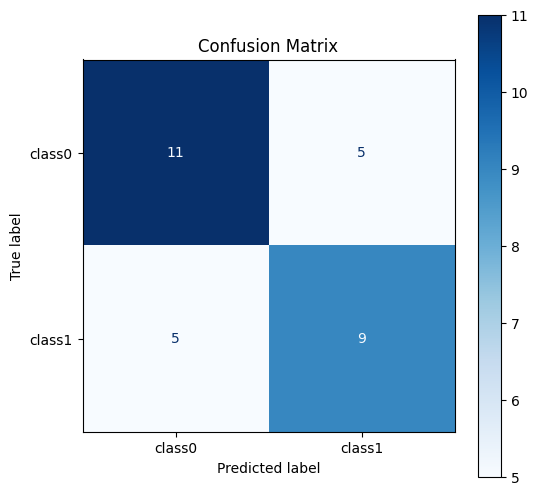

In [22]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice

def predict(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in tqdm(islice(loader, 3)):
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.show()
# ËºâÂÖ•Ê®°ÂûãÊ¨äÈáçÔºåË®≠ÂÆödeviceÁ≠â

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = x3d_xs(pretrained=True)  # ËºâÂÖ•È†êË®ìÁ∑¥ÁöÑX3D XSÊ®°Âûã
model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)  # ‰øÆÊîπÊúÄÂæåÂàÜÈ°ûÂ±§ÁÇ∫2ÂàÜÈ°û
model.load_state_dict(torch.load('/content/drive/MyDrive/epoch_1_valacc_0.540669856.pt', map_location=device))
model.to(device)

# ÂÅáË®≠‰Ω†Êúâval_loader
preds, labels = predict(model, val_loader, device)

# ÂÅáË®≠‰∫åÂàÜÈ°ûÔºåclass_namesÂèØËá™Â∑±ÂÆöÁæ©
class_names = ["class0", "class1"]

plot_confusion_matrix(labels, preds, class_names)
